In [1]:
## import pathlib
import re
from tqdm import tqdm
import typing
from pprint import pprint as pp
import json
from nltk.tokenize import WhitespaceTokenizer, word_tokenize
import arviz as az
import numpy as np
from collections import Counter, defaultdict
import pathlib
import pandas as pd
from itertools import permutations, chain
import string
import matplotlib.pyplot as plt
import copy

tqdm.pandas()

In [2]:
# import torch
# import torch.nn.functional as F
from transformers import AutoTokenizer
import numpy as np
import arviz as az
import pymc as pm
import math

# Load American literature fiction quotes

## Load the quotes

In [ ]:
# with open('/home/ry/Projects/DH_Benelux2024_but_they_do_talk_a_bit_funny/PG/extract_quotes_via_spaCy/quotes_5Jul.json', 'r') as f:
#     quotes_all = pd.DataFrame([t for i,t in enumerate(json.load(f))], columns = ["id", "p", "quote", "manner", "speaker"])
# quotes_all['i'] = list(range(len(quotes_all)))

In [3]:
with open('../../PG/extract_quotes_via_spaCy/quotes_blacklist.json', 'r') as f:
    PG_blacklist = json.load(f) 

In [4]:
with open('../../PG/extract_quotes_via_spaCy/quotes_5Jul.json', 'r') as f:
    PG_df = pd.DataFrame([t for i,t in enumerate(json.load(f))], columns = ["id", "p", "quote", "manner", "speaker"])
PG_df['i'] = list(range(len(PG_df)))

In [5]:
# ignore (as done for chains) ... those quotes in blacklist or not of speakers of interest
speakers_of_interest = set(['man', 'woman', 'child', 'gentleman', 'lady', 'negro', 'Negro'])
PG_df = PG_df.loc[(PG_df.loc[:,'i'].isin(PG_blacklist)==False)&(PG_df.loc[:,'speaker'].isin(speakers_of_interest)==True),:]

In [6]:
# reset indices, reset 'i'
PG_df.reset_index(drop=True, inplace=True)
PG_df['i'] = list(range(len(PG_df)))

In [7]:
list(PG_df.loc[PG_df.loc[:,"speaker"].isin(['negro', 'Negro']),'quote'])

['"Howdy, Marse Stephen,"',
 '"I seed yo\' ma yestiddy en she sutney wuz lookin well an\' peart."',
 '"None, suh?"',
 '"Well, suh,"',
 '"Dey won\'t find \'em,"',
 '"I\'m coming, suh!"',
 '"Yes, mistis,"',
 '"I ain\'t a gwine to stay here, missis,"',
 '"for any money in dis world, and if dey wont let me go out wid you, I will come arter you by myself."',
 '"His name is Mr. Alfred Wentworth,"',
 '"Top a bit, mistis, an\' I will fix de little gal for you,"',
 '"Dar now,"',
 '"did not I tell you dat de sweet little child was libbing."',
 '"What make you come to dis part ob town to-night, missis,"',
 '"I don\'t know, but I spect it will do,"',
 '"Don\'t cry chile,"',
 '"Dat\'s a good gal,"',
 '"you tell him dat I want to see him, but don\'t tell him what I want him for--I rader tell him dat mysef."',
 '"Jes de lubliest baby you eber seed in your life,"',
 '"Why de lady and childen dat come to my cabin was from New Orleans too,"',
 '"Dat\'s it,"',
 '"dat\'s de berry name!"',
 '"Poh lady,"',


## Load the chained probabilities wrt., quotes

(already removed of blacklisted quotes)

In [8]:
chains_dir = pathlib.Path('../../PG/Snellius/mwcgln/llama3.1_70B/')

# get orders list of chains fps - they need to be re-assembled in this order, to correspond to 
ordered_chains_fps = sorted(list(chains_dir.glob('*.json')), key=lambda c: int(re.search(r"_(\d+)\.json", str(c)).groups()[0]))

# re-assemble
PG_chains = []
for chain_fp in tqdm(ordered_chains_fps):
    with open(chain_fp, 'r') as f:
        PG_chains += json.load(f)
len(PG_chains)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.29it/s]


26502

In [9]:
# chains - quotes
len(PG_chains) - len(PG_df)

0

# Tokenisation

In [10]:
tokenizer = AutoTokenizer.from_pretrained('../llama3.1_70B/tokenizer/')

In [11]:
tk = WhitespaceTokenizer()
whitespace_tokenize = tk.tokenize

In [12]:
## let's double check how the tokenizer handles various examples of punctation ...

# note: the tokenizer tokenizes, and there's nothing we can do about those 
#       subtoken choices. However, what's important to us is that we correctly
#       partition them into 'words', for perplexity calculations

test_cases = [
    '"Howdy, Marse Stephen,"',
    "what is this life (if full of care).",
    "what is this life [if full of care].",
    "what is this life {if full of care}.",
    "what is this life, if full of care.",
    "what is this life, if full of care?",
    "what is this life, if full of care!",
    "what is this life: if full of care.",
    "what is this life; if full of care.",
    "what is this life ... if full of care.",
    "what is this,(life) ... if full of care.",
]

for test_case in test_cases:
    print(test_case)
    print('\t' + str(tokenizer.tokenize(test_case)))

"Howdy, Marse Stephen,"
	['"How', 'dy', ',', 'ĠM', 'arse', 'ĠStephen', ',"']
what is this life (if full of care).
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ(', 'if', 'Ġfull', 'Ġof', 'Ġcare', ').']
what is this life [if full of care].
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ[', 'if', 'Ġfull', 'Ġof', 'Ġcare', '].']
what is this life {if full of care}.
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ{', 'if', 'Ġfull', 'Ġof', 'Ġcare', '}.']
what is this life, if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life, if full of care?
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '?']
what is this life, if full of care!
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '!']
what is this life: if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ':', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life; if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ';', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this 

In [13]:
words = re.split(r"(-{2,}|\.\.\.|Mr\.|Mrs\.|Dr\.|Prof\.|[A-Z]\.|[^A-Za-z0-9_'-]+)", "Hello Mr. Smith")
[word for word in words if word != ""]

['Hello', ' ', 'Mr.', ' ', 'Smith']

In [14]:
def get_words(s:str)->list[str]:
    """ split into words, ensure that contractions aren't split
        Note: This is my N wrt., 
        Note: why not word_tokenize() ? ... because it splits contractions
    """

    # split on whitespace
    words = whitespace_tokenize(s)

    # split off cases where word is enclosed by '' or `'
    words_ = []
    for word in words:
        if (word[0] == "'" and word[-1] == "'") or (word[0] == "`" and word[-1] == "'") or (word[0] == "\"" and word[-1] == "\""):
            words_.append(word[0])
            words_.append(word[1:-1])
            words_.append(word[-1])
        else:
            words_.append(word)
    words = words_
    

    # split of multiple hyphens, elipses, honorifics, initial (followed by dot), non alphanumeric/hyphen/apostrophe
    words_ = []
    for word in words:
        words_ += re.split(r"(-{2,}|\.\.\.|Mr\.|Mrs\.|Dr\.|Prof\.|[A-Z]\.|[^A-Za-z0-9_'-])", word)
    words = words_

    # finally, remove empty strings
    words = [word for word in words if word != ""]

    return words
                
    
def get_words_indices(words, tokens):

    words_indices = []

    tokens_ = [token[1:] if token[0] == "Ġ" else token for token in tokens]

    w = 0
    state = ["", [], True]  # accum of tokens, assum token indices, add to state?

    i = 0
    
    while i < len(tokens_):

        token = tokens_[i]

        if tokens[i][-1] == "Ġ":  # we have \s+ that's been mapped to a token ... skip it ... it's rare
            i+=1
            continue            
        
        # add more tokens to state and record the previous state
        if state[2] == True:
            state[0] += token
            state[1].append(i)

        # we've completed a word!
        if state[0] == words[w]:
            words_indices.append(state[1])
            w += 1
            state = ["", [], True]

        # state exceeds current word ... we have tokens what span words
        elif state[0][:len(words[w])]==words[w]:
            
            # add a decimal to indicate the root to take from token common between words
            excess = len(state[0]) - len(words[w])
            wanted = len(token) - excess
            state[1][-1] = state[1][-1] + wanted/len(token)

            words_indices.append(state[1])
            w+=1

            # init state for next word, incorporating excess of common token
            state = [token[-excess:], [i + (excess / len(token))], False]

            continue

        i += 1

    return words_indices
            
        
# test
# s = "what is this lif', if fulling!..."s
s = "it is the parents', not the children's"
words = get_words(s)
tokens = tokenizer.tokenize(s)
print(words)
print(tokens)
words_indices = get_words_indices(words, tokens)
print(words_indices)

# yields [[0], [1], [2], [3, 4.2], [4.2], [6, 7]], where 4.2 means we take square root wrt., token 4 probability as estimated contribution to prob chain

['it', 'is', 'the', "parents'", ',', 'not', 'the', "children's"]
['it', 'Ġis', 'Ġthe', 'Ġparents', "',", 'Ġnot', 'Ġthe', 'Ġchildren', "'s"]
[[0], [1], [2], [3, 4.5], [4.5], [5], [6], [7, 8]]


In [15]:
# test skipping tokens used represent contiguous spaces
s = "what is this    life"
words = get_words(s)
tokens = tokenizer.tokenize(s)
print(words)
print(tokens)
get_words_indices(words, tokens)

['what', 'is', 'this', 'life']
['what', 'Ġis', 'Ġthis', 'ĠĠĠ', 'Ġlife']


[[0], [1], [2], [4]]

In [16]:
s = "Gimme dat ar axe"
tokenizer.tokenize(s)

['G', 'im', 'me', 'Ġdat', 'Ġar', 'Ġaxe']

## ignore quotations (and corresponding chains) with encoding issues

In [17]:
bad_encoding_i = []
bad_encoding_speakers = Counter()
for i, (q, speaker) in enumerate(zip(PG_df.loc[:,'quote'], PG_df.loc[:,'speaker'])):
    try:
        s = q[1:-1]
        words = get_words(s)
        tokens = tokenizer.tokenize(s)
        words_indices = get_words_indices(words, tokens)

        assert len(words) == len(words_indices)
    except:
        bad_encoding_i.append(i)
        bad_encoding_speakers[speaker] += 1

display(bad_encoding_i)
display(bad_encoding_speakers)

[399,
 1199,
 3217,
 3880,
 3882,
 3995,
 3997,
 4401,
 5371,
 5878,
 5881,
 5884,
 5885,
 6795,
 7345,
 7347,
 7349,
 7350,
 7352,
 7353,
 7358,
 7362,
 7364,
 7765,
 8793,
 8803,
 9064,
 10471,
 12156,
 12194,
 12670,
 13484,
 13525,
 14547,
 15114,
 16441,
 16461,
 17035,
 17101,
 17106,
 18217,
 18809,
 19027,
 19129,
 19603,
 20159,
 20164,
 20467,
 21675,
 21676,
 22704,
 22771,
 23625,
 24905,
 25744,
 25756,
 25765,
 26422]

Counter({'man': 39, 'lady': 6, 'negro': 6, 'woman': 5, 'gentleman': 2})

In [18]:
# drop from quotes
PG_df.drop(bad_encoding_i, inplace=True)
PG_df.reset_index(drop=True, inplace=True)
PG_df['i'] = list(range(len(PG_df)))

In [19]:
PG_df

,id,p,quote,manner,speaker,i
0,8711,183,"""Mr. Wiggins,""",said,man,0
1,8711,221,"""But I've got to obey orders,""",said,man,1
2,8711,498,"""Sorry, mum, to refuse; but orders is orders, ...",said,man,2
3,8711,523,"""Mr. Wiggins presents his respects, mum,""",said,man,3
4,8711,523,"""and says he is not breakin' any law at all, a...",said,man,4
...,...,...,...,...,...,...
26439,19746,948,"""The woman has had a stroke,""",said,gentleman,26439
26440,19746,948,"""brought on by brutal treatment. By G--d, Dudl...",said,gentleman,26440
26441,19746,1079,"""Oh, I beg pardon,""",said,man,26441
26442,19746,1079,"""I took you for a nigger.""",said,man,26442


In [20]:
# drop from chains
for i in sorted(bad_encoding_i, reverse=True):
    del PG_chains[i]

In [21]:
display(len(PG_df))
display(len(PG_chains))

26444

26444

## Add Surprisals to quotes


In [22]:
import math

def get_surprisals(words, tokens, chain):

    variation_surprisal = []
    
    for word, word_indices in zip(words, get_words_indices(words, tokens)):
        
        # are word_indices a decimal? then we need to apply a power to the probability, to split a token that spans words
        powers, indices = zip(*[math.modf(i) for i in word_indices])
        powers = np.array([1 if p == 0 else p for p in powers])
        indices = [int(i) for i in indices]

        # log(x^p) = p*log(x)
        word_surprisal = (-np.log(chain[indices])*powers).sum()
        variation_surprisal.append(word_surprisal)

    return variation_surprisal

In [23]:
PG_df["words"] = PG_df["quote"].progress_apply(lambda x: get_words(x[1:-1]))


100%|█████████████████████████████████| 26444/26444 [00:00<00:00, 111161.62it/s]


In [24]:
PG_df['surprisals'] = [get_surprisals(PG_df.loc[i, 'words'], tokenizer.tokenize(PG_df.loc[i, 'quote'][1:-1]), np.array(PG_chains[i][1:])) for i in tqdm(range(len(PG_df)))]


100%|██████████████████████████████████| 26444/26444 [00:02<00:00, 12999.96it/s]


In [ ]:
# PG_df['quotation_Av_surprisal'] = PG_df['surprisals'].progress_apply(lambda x: np.array(x).mean())

# Deviation between observed mean LLM surprisal over words

Average quotation mean Surprisal ['man'] 14.009885343435892
Average quotation mean Surprisal ['woman'] 13.94651270341869
Average quotation mean Surprisal ['gentleman'] 13.65683306288121
Average quotation mean Surprisal ['lady'] 13.509539118585584
Average quotation mean Surprisal ['child'] 13.800026563252217
Average quotation mean Surprisal ['negro', 'Negro'] 15.267566609622147
negro,Negro - man = 1.257681266186255
(negro,Negro - man) / man = 8.97709892233716
negro,Negro - woman = 1.3210539062034563
(negro,Negro - woman) / woman = 9.47228840855412
negro,Negro - gentleman = 1.6107335467409367
(negro,Negro - gentleman) / gentleman = 11.794341626089388
negro,Negro - lady = 1.7580274910365628
(negro,Negro - lady) / lady = 13.013230692807113
negro,Negro - child = 1.4675400463699297
(negro,Negro - child) / child = 10.63432769236698
negro,Negro - negro,Negro = 0.0
(negro,Negro - negro,Negro) / negro,Negro = 0.0


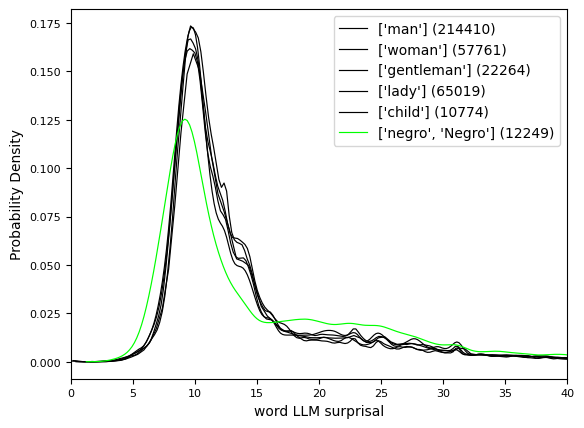

In [25]:
# quotation Average Surprisals
tendencies = {}
for i, (speakers, color) in enumerate([(["man"], "black"), (["woman"], "black"), (["gentleman"], "black"), (["lady"], "black"), (["child"], "black"), (["negro", "Negro"], "lime")]):

    data = np.array(list(chain(*PG_df.loc[PG_df.loc[:,'speaker'].isin(speakers), 'surprisals']))) # mean LLM surprisal by quotation
    # data = np.array(PG_df.loc[PG_df.loc[:,'speaker'].isin(speakers), 'quotation_Av_surprisal']) # LLM surprisals by words
    az.plot_kde(data, label=f"{speakers} ({len(data)})", textsize=8, plot_kwargs={'color':color});
    
    plt.xlabel("word LLM surprisal")
    plt.ylabel("Probability Density")
    plt.xlim(0, 40)

    plt.savefig('RQ_1_word_surprisal_overlay')

    # est. means
    print("Average quotation mean Surprisal", speakers, data.mean())
    tendencies[",".join(speakers)] = data.mean()

for k, v in tendencies.items():
    print(f"negro,Negro - {k} = {tendencies['negro,Negro']-v}")
    print(f"(negro,Negro - {k}) / {k} = {100*(tendencies['negro,Negro']-v)/v}")

# Deviation between LATENT mean LLM surprisal over words

In [27]:
# Plotting helper functions
# adapted from https://github.com/dustinstansbury/statistical-rethinking-2023/blob/main/Lecture%2004%20-%20Categories%20%26%20Curves.ipynb

# Note: use plot_posterior_estimates.py where only posterior plot wanted (faster)
def plot_posterior_trace(trace)->None:
    """ Plot:
            i) trace plots
            ii) posterior parameter distributions, i.e., P(parameter=value | data)

        Args:
            trace (arviz.data.inference_data.InferenceData)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
        
        
def plot_posterior_estimates(trace, size: int = 1000, kind: str = "auto") -> dict:
    """Plot posterior parameter samples, i.e., P(parameter=value | data)

    Args:
        trace (arviz.data.inference_data.InferenceData)
        size (int): size of subsample to plot from complete set of posterior samples
            Note: max sample size of chains*draws (see trace.posterior)
        kind (str): arviz.plot_dist kind  (i.e., 'hist', 'kde', 'auto')

    Return a dict of posterior samples by parameters
    """
    # get the parameter names, for which there's a posterior est.
    var_names = [name for name in trace.posterior]

    # set up the plot
    fig, axs = plt.subplots((len(var_names)))
    fig.tight_layout()

    # MCMC samples the parameter space for all parameters simultaneously
    # we sample these (stacked) chain & draw instances
    # yields and xarray.core.dataset.Dataset, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)  

    # for each parameter ... plot the sample_subset
    d = {}
    for i, (var_name) in enumerate(var_names):
        
        if len(var_names) > 1:
            plt.sca(axs[i])
        else:
            pass

        # get posterior samples wrt., var_name
        draw_samples = sample_subset[var_name]
        d[var_name] = draw_samples

        # get random samples of
        az.plot_dist(draw_samples, kind=kind, label=f"{var_name}")

    return d

import typing

import arviz as az
import matplotlib.pyplot as plt
import numpy as np


def plot_posterior_estimates_contrast(
    trace: az.data.inference_data.InferenceData,
    size: int = 1000,
    pairs: list[tuple] = [],
    kind: str = "auto",
) -> list:
    """ For each (param1::str, param2::str) pair in 'pairs' ...
        plot distribution of corresponding (param1 - param2) samples.

        where corresponding means the same chain&draw

        Args:
            trace ():
            size (int): sample size
                Note: max sample size of chains*draws (see trace.posterior)
            pairs (list[tuple]):
            kind (str):

        Returns a list of each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    # get sample_subset (of the posterior samples)
    #   yields xarray.core.dataset.Dataset object, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)

    # init plot
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()

    # plot contrasts
    contrasts = []
    for i, (p1, p2) in enumerate(pairs):

        # get posterior contrast
        pc = sample_subset[p1] - sample_subset[p2]
        
        # set current subplot
        if len(pairs) > 1:
            plt.sca(axs[i])
        else:
            pass

        # plot
        az.plot_dist(pc, color=f"C{i}", kind=kind, label=f"{p1}-{p2}")

        # record the posterior contrast for the sample_subset, wrt., the pair
        contrasts.append(pc)

    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()

    return contrasts


def plot_posterior_predictive_overlay(model, trace, size=1000)->None:
    """ (density) plots of estimand predictions (based on parameter posteriors) against the observed

        Args:

            model (pymc.model.core.Model)
            trace (arviz.data.inference_data.InferenceData)
            size (int): the number of posterior predictions to obtain and plot

        Returns a {'estimand': posterior_predictive_samples::np.ndarray, ...} 
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: arviz.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )
        # NOTE: preds[var].shape=(chains, draws, len(observed_originally_fed_to_estimator))

    
    # for each estimand, sample preditions and record a (predictions, observed) tuple
    d = {}  # d['estimand'] = (p::np.ndarray, o::np.ndarray)
    for i, estimand in enumerate(post_pred.posterior_predictive):

        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[estimand].dims  # (chains, draws, len(observed))
        p: np.ndarray = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),  # 1D array of all estimand predictions
            size,
            replace=True,
        )

        # p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))

        o: np.ndarray = post_pred.observed_data[estimand].to_numpy()
        d[estimand] = (p, o)  # (predicted, observed)

        # Note: it doesn't matter that we have a different numbe

    # set up plots
    num_estimands = len(post_pred.posterior_predictive)
    fig, axs = plt.subplots(num_estimands)
    fig.tight_layout(h_pad=4)

    # plot observed vs predicted for each estimand
    for i, estimand in enumerate(post_pred.posterior_predictive):

        if num_estimands > 1:
            plt.sca(axs[i])
        else:
            pass

        # az.plot_kde(d[estimand][0], label="predicted", plot_kwargs={'color':'black'})
        # az.plot_kde(d[estimand][1], label="observed", plot_kwargs={'color':'grey'})

        plt.hist(
            [d[estimand][0], d[estimand][1]], label=["predicted", "observed"], density=True, bins=int(np.sqrt(size))
        )
        plt.xlabel(estimand)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)

    return d

## Note: could also use arviz for this:
# with model:
#   post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
# az.plot_ppc(post_pred, num_pp_samples=100)


def plot_posterior_predictive_qq(model, trace, size: int = 1000) -> None:
    """QQ plots comparing predictions and observed estimands

    Args:
        model (pymc.model.core.Model)
        trace (arviz.data.inference_data.InferenceData)
        size (int): the number of estimands to simulate
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: az.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )

    # set up the plots
    fig, axs = plt.subplots(len(post_pred.posterior_predictive))
    fig.tight_layout(h_pad=4)

    for i, estimand in enumerate(post_pred.posterior_predictive):

        # set current subplot
        try:
            plt.sca(axs[i])
        except:
            pass

        # sample predictions
        p_dims = post_pred.posterior_predictive[estimand].dims
        p_sample = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),
            size,
            replace=True,
        )

        # get quantiles
        quantiles = np.linspace(0,1,11)

        # predicted estimand quantiles
        p_quantiles = np.quantile(
            p_sample,
            quantiles
        )

        # observed estimand quantiles
        o_quantiles = np.quantile(
            post_pred.observed_data[estimand].to_numpy(),
            quantiles
        )

        # plot
        plt.scatter(o_quantiles, p_quantiles)
        plt.axline([0,0], [1,1], linestyle='--')
        plt.title(f'Q-Q plot wrt., {estimand}')
        plt.xlabel('observed estimand quantiles')
        plt.ylabel('predicted estimand quantiles')

        
def get_hdi(d: np.ndarray, hdi=0.89)->tuple[float]:
    """ Return (lowerbound::float, upperbound::float) wrt.,
        prescribed highest density interval
    """
    lb = (1-hdi)/2
    ub = hdi+lb
    return (np.quantile(d, lb), np.quantile(d, ub))


def cohens_d(mu1, mu2, sigma1, sigma2)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """
    # pooled standard dev
    pooled = np.sqrt((sigma1**2 + sigma2**2)/2)

    # posterior estimates of cohen's d
    return (mu1-mu2) / pooled

## E.g.,
# mu1 = trace.posterior['mu1'].stack(sample=('chain', 'draw')).to_numpy()
# mu2 = trace.posterior['mu2'].stack(sample=('chain', 'draw')).to_numpy()  
# sigma1 = trace.posterior['sigma1'].stack(sample=('chain', 'draw')).to_numpy()
# sigma2 = trace.posterior['sigma2'].stack(sample=('chain', 'draw')).to_numpy()
# posterior_d = cohens_d(mu1, mu1, sigma1, sigma2)

## E.g., to plot:
# import arviz as az
# import matplotlib.pyplot as plt
# az.plot_dist(posterior_d, kind='kde')

def glass_delta(mu_ref, mu2, sigma_ref)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """

    # posterior estimates of cohen's d
    return (mu2-mu_ref) / sigma_ref


    
    
    

how skewed are the populations?

too skewed for normalality assumption ... use a method without distribuitonal assumptions

In [28]:
from scipy.stats import skew
for speakers in [["Negro", "negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]:
    data = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers), "surprisals"])))
    print(speakers, skew(data))

['Negro', 'negro'] 1.8869199083702295
['man'] 2.8612492873359083
['woman'] 2.4031041227023
['child'] 2.2320806920931453
['gentleman'] 2.769662929612944
['lady'] 2.9623411118590957


In [29]:
def bayesian_bootstrapping(data, a=3, target_accept=0.95):
    with pm.Model() as model:

        w = pm.Dirichlet("w", a=np.ones(len(data))*a)
        
        mean = pm.Deterministic("mean", pm.math.sum(w * data))

        ## using NUTS sampler
        trace = pm.sample(target_accept=target_accept)
        
    return model, trace

## Test case ... how does 10000 datapoints do?

looks good!

In [30]:
speakers = ["child"]
np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers), "surprisals"]))).mean()

13.800026563252217

In [31]:
# speakers = ["child"]
# data = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers), "surprisals"])))
# sample_data = np.random.choice(data, size=10000)
# model, trace = bayesian_bootstrapping(sample_data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Output()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ValueError: Not enough samples to build a trace.

In [ ]:
# plot_posterior_estimates(trace);

## Sample population for each speaker, and run the analysis on snellius

(each analysis of 10,000 samples takes about 20 mins)

In [ ]:
# for speakers in [["Negro", "negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]:
#     s = ",".join(speakers)
#     data = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers), "surprisals"])))
#     sample_data = list(np.random.choice(data, size=10000))

#     with open(f"RQ1_latent_sample_10000_{s}", "w") as f:
#         json.dump(sample_data, f)

## Load the traces, examine and compare

In [32]:
traces = {}
for speakers in [["Negro","negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]:
    s = ",".join(speakers)
    traces[s] = az.from_netcdf(f'RQ1_population_samples/TRACE_{s}.nc')

let's look at the posterior plots

In [33]:
for speakers in [["Negro","negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]:
    s = ",".join(speakers)
    posterior_samples = az.extract(traces[s], var_names=['mean'], combined=True)
    lb, ub = get_hdi(posterior_samples)
    print(s, f"{lb:.1f}", f"{ub:.1f}")

Negro,negro 15.2 15.3
man 13.9 14.1
woman 14.0 14.2
child 13.7 13.9
gentleman 13.7 13.9
lady 13.4 13.6


In [34]:
S = list(traces.keys())
# for i, s1 in enumerate(S[:-1]):
for i, s1 in enumerate(S):
    posterior_samples1 = az.extract(traces[s1], var_names=['mean'], combined=True)
    # for s2 in S[i+1:]:
    for s2 in S:
        posterior_samples2 = az.extract(traces[s2], var_names=['mean'], combined=True)

        pc = 100*(posterior_samples1 - posterior_samples2) / posterior_samples2
        lb,ub = get_hdi(pc, hdi=0.99)
        print(f"{s1} - {s2}", f"{lb:.1f}", f"{ub:.1f}")


Negro,negro - Negro,negro 0.0 0.0
Negro,negro - man 7.7 10.4
Negro,negro - woman 7.0 9.6
Negro,negro - child 9.3 12.0
Negro,negro - gentleman 9.3 12.1
Negro,negro - lady 11.7 14.4
man - Negro,negro -9.4 -7.2
man - man 0.0 0.0
man - woman -1.9 0.4
man - child 0.3 2.6
man - gentleman 0.3 2.7
man - lady 2.5 4.9
woman - Negro,negro -8.7 -6.5
woman - man -0.4 1.9
woman - woman 0.0 0.0
woman - child 1.0 3.3
woman - gentleman 1.0 3.4
woman - lady 3.2 5.7
child - Negro,negro -10.7 -8.5
child - man -2.5 -0.3
child - woman -3.1 -1.0
child - child 0.0 0.0
child - gentleman -1.0 1.3
child - lady 1.2 3.3
gentleman - Negro,negro -10.8 -8.5
gentleman - man -2.6 -0.3
gentleman - woman -3.3 -1.0
gentleman - child -1.3 1.0
gentleman - gentleman 0.0 0.0
gentleman - lady 1.0 3.3
lady - Negro,negro -12.6 -10.5
lady - man -4.6 -2.4
lady - woman -5.4 -3.1
lady - child -3.2 -1.2
lady - gentleman -3.2 -1.0
lady - lady 0.0 0.0


# Examination of variations


## load an english dict

In [ ]:
# import nltk
# nltk.download('wordnet')
# from nltk.corpus import wordnet as wn

# en_words = []
# for synset in wn.all_synsets():  # Iterate through all synsets
#     for lemma in synset.lemmas():  # Get each lemma (word)
#         word = lemma.name().replace('_', ' ')  # Replace underscores with spaces
#         en_words.append(word)
        
# en_words += [w.capitalize() for w in en_words]
# en_words = set(en_words)
# len(en_words)


In [35]:
# scowl english words en_us large
with open('../../wordlist-en_US-large-2020.12.07/en_US-large.txt', 'r') as f:
    en_words = [line.strip('\n') for line in f.readlines()]
en_words += [w.capitalize() for w in en_words]
en_words = set(en_words)
len(en_words)

303817

In [ ]:
# from nltk.corpus import words
# en_words = words.words()
# en_words += [w.capitalize() for w in en_words]
# en_words = set(en_words)
# len(en_words)

In [ ]:
# # load a dict: same as above
# with open("/usr/share/dict/words", "r") as f:
#     en_words = [x.strip("\n") for x in f.readlines()]
# en_words += [w.capitalize() for w in en_words]
# en_words = set(en_words)
# len(en_words)

## load CMU arpabet

In [36]:
# import
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

# ignore stresses as deep phenomizer doesnt have these
word2arpa = defaultdict(list)
for line in lines:
    splits = [split for split in line.split(" ") if split != '']
    word = splits[0].split('(')[0]
    arpa = "".join(['[' + split.translate(str.maketrans('', '', '0123456789')) + ']' for split in splits[1:]])
    if word not in word2arpa: # just get the main pronunciaion
        word2arpa[word].append(arpa)

word2arpa['WAS']

['[W][AA][Z]']

## load deep phenomizer

In [37]:
# load dp
from dp.phonemizer import Phonemizer
phonemizer = Phonemizer.from_checkpoint('./en_us_cmudict_forward.pt')
phonemizer('WAS', lang='en_us')

/opt/miniconda3/envs/bigone/lib/python3.11/site-packages/dp/model/model.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_lo

'[W][AA][Z]'

## add functions for estimating phonetic changes between 2 textual representations of a word

In [38]:
def arpaguess(s:str):
    if s.upper() not in word2arpa:
        return [phonemizer(s, lang='en_us')]
    else:
        return word2arpa[s.upper()]

arpaguess("going")

['[G][OW][IH][NG]']

In [39]:
import difflib
def get_changes(from_:list[str], to_:list[str], return_indices=False)->bool:

    # accumulator
    changes = []

    # state
    in_change = False

    for x in difflib.ndiff(from_, to_): #iterate over diff
        # print(x, in_change)
        
        if x[0] == "+" or x[0] == "-":  # change detected
            sign, entry = x.split(" ")

            # new change? then init addition to changes
            if in_change == False:
                changes.append([[], []])
            
            # regardless, record state
            in_change = True

            # regardless, capture changes
            if sign == '-':
                changes[-1][0].append(entry)
            elif sign == '+':
                changes[-1][1].append(entry)

        elif x[0] == "?":
            pass
            
        else:  # match detected
                
            # regardless, record state    
            in_change = False

    return changes
            
print(get_changes(['a','b','b','c','e'], ['a','b','d','e']))
print(get_changes(["it", "oughta", "happen"], ["it", "ought", "to", "happen"]))
print(get_changes("it oughta happen".split(), "it ought to happen".split()))
list(difflib.ndiff(["it", "oughta", "happen"], ["it", "ought", "to", "happen"]))
    

[[['b', 'c'], ['d']]]
[[['oughta'], ['ought', 'to']]]
[[['oughta'], ['ought', 'to']]]


['  it', '- oughta', '?      -\n', '+ ought', '+ to', '  happen']

In [41]:
# test
from_ = re.findall(r"\w+", arpaguess("thing")[0])
to_ = re.findall(r"\w+", arpaguess("ding")[0])
get_changes(from_, to_)


[[['TH'], ['D']]]

In [43]:
# test
from_ = re.findall(r"\w+", arpaguess("master")[0])
to_ = re.findall(r"\w+", arpaguess("marster")[0])
get_changes(from_, to_)

[[['AE'], ['AA', 'R']]]

In [44]:
word = "hyar"
# speakers = ['negro', 'Negro']
speakers = ['woman']
for q in PG_df.loc[(PG_df.loc[:, 'words'].apply(lambda x: word in x))&(PG_df.loc[:,'speaker'].isin(speakers)), 'quote']:
    print(q.replace(word, '<<'+word+'>>'))

"Look a <<hyar>>, young feller,"
"Look a <<hyar>>, young feller,"
"Elder Jones buried Bill in Tantallon buryin' ground, four mile from <<hyar>> down the track,"
"Want! Yuh jes' step in <<hyar>> one minute."
"Bress you, honey, dar's a right smart chance o' dem ar' critter-back fellers out yander, all a-holdin' guns an' sich like, w'at tole me was you <<hyar>>? Den I tole _dem_, I dunno; 'spect you done gwine away; 'cause I didn't know w'at dey wanted, an' didn't know mebbe you'd want to hide. Den a gre't big feller, no 'count w'ite trash, he said, 'G'long, dar, you 'sense o' midnight you, an' tell him to show hissef, or I brow de whull top o' y'ur head offen you!' Den I say, 'Git out, you dirty w'ite nigger'--"
"Missy be keerful <<hyar>>,"


## identify the out of dictionary words for each speaker and save to RQ1_ood_words

Note: "de" is in en_words: we remove it.


ignore the following cases:

    non-english or non-english contexts

    standard contractions ('ll, 's, 'd, 've, n't, 'm, 're, ') where the part before the contaction is in the dict

    archaic contractions: thou'lt

    hyphenated words, where each word is in dictionary

    words ending with a hyphen, where the word is in the dict

    dialect words: 

    regularised irregular verbs: knowed, throwed, brung, threated, heared, blowed, arrove, tooken, runned, drownded, tookened, tored, borned, buyed

    non-canonical pluralisation: mens, somewheres

In [53]:
def is_standard_contr(word:str)->bool:
    # ignore standard contractions 'll, 's, 'd, 've where, the 'stem' is in dict
    if (word[-3:] == "'ll" and word[:-3] in en_words) or (word[-3:] == "'ve" and word[:-3] in en_words) or (word[-2:] == "'s" and word[:-2] in en_words) or (word[-3:] == "n't" and word[:-3] in en_words) or (word[-3:] == "'re" and word[:-3] in en_words)  or (word[-2:] == "'d" and word[:-2] in en_words) or (word[-2:] == "'m" and word[:-2] in en_words) or (word[-1:] == "'" and word[:-1] in en_words):
        return True
    else:
        return False

def is_hyphenated(word:str)->bool:
    if all([w in en_words for w in word.split('-')]):
        return True
    else:
        False

In [96]:
## extracts ood words by speaker and saves as json ... 

# X = [["negro","Negro"], ['man'], ['woman'], ['gentleman'], ['lady'], ['child']]
X = [["negro"]]
for i, speakers in enumerate(X):
    s = ",".join(speakers)
    ood_words = set([word for word in chain(*PG_df.loc[PG_df.loc[:,'speaker'].isin(speakers), 'words']) if not (word.strip('-') in en_words or word in string.punctuation or is_standard_contr(word.strip('-')) or word.isnumeric() or is_hyphenated(word))])
    # with open(f"RQ1_ood_words/RQ1_ood_words_{s}_pre.json", 'w') as f:
    #         json.dump({word:[] for word in ood_words}, f)


In [97]:
"Don't" in ood_words

False

In [98]:
w_ = "wine"
set([w for w in chain(*PG_df.loc[PG_df.loc[:,'speaker'].isin(["Negro", 'negro']), 'words']) if w_ in w])

{'Radwine', 'a-gwine', 'agwine', 'ergwine', 'gwine', 'gwineter'}

In [99]:
for w_ in ["i's", "i'se", "dey'se", "dey's", "they's", "they'se", "we's", "we'se", "you'se", "you's", "gwine", "agwine", "a-gwine", "ergwine", "yas'm", "yassum"]:
    # print(w_, sum([1 for w in chain(*PG_df.loc[PG_df.loc[:,'speaker'].isin(["Negro", 'negro']), 'words']) if w == w_ or w==w_.capitalize()]))
    print(w_, sum([1 for w in chain(*PG_df.loc[:, 'words']) if w == w_ or w==w_.capitalize()]))


i's 20
i'se 31
dey'se 1
dey's 12
they's 5
they'se 0
we's 9
we'se 1
you'se 9
you's 8
gwine 81
agwine 16
a-gwine 8
ergwine 8
yas'm 3
yassum 2


## Next step is remove the ignore list (manually)...

...

## How many corrections by speaker? 

In [100]:
for speakers in [["Negro", "negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"]]:
    s = ",".join(speakers)
    with open(f"RQ1_ood_words/RQ1_ood_words_{s}.json", "r") as f:
        annotations = json.load(f)

    print(s, sum([1 for k, v in annotations.items() if len(v) == 1]))

Negro,negro 742
man 1564
woman 779
child 119
gentleman 125
lady 184


# Explaining $\Delta_{\text{ref}}$ by words demonstrative of targeted variations


## variations targetted

identified dialect words (in nword attributed quotatons)

In [101]:
# get corrections for italicised words
def is_italicised(word:str)->bool:
    if len(word) > 2:
        if word[0] == "_" and word[-1] == "_":
            return True
    return False

italicised_words = {word:word.strip("_") for word in list(chain(*PG_df.loc[:, "words"])) if is_italicised(word)}
list(italicised_words.items())[:20]


[('_is_', 'is'),
 ('_me_', 'me'),
 ('_wish_', 'wish'),
 ('_never_', 'never'),
 ('_must_', 'must'),
 ('_so_', 'so'),
 ('_companion_', 'companion'),
 ('_Dat_', 'Dat'),
 ('_news_', 'news'),
 ('_Miss_', 'Miss'),
 ('_us_', 'us'),
 ('_her_', 'her'),
 ('_And_', 'And'),
 ('_Onondago_', 'Onondago'),
 ('_hire_', 'hire'),
 ('_sure_', 'sure'),
 ('_now_', 'now'),
 ('_did_', 'did'),
 ('_that_', 'that'),
 ('_Mail_', 'Mail')]

In [102]:

dialect_words1 = {
 "i's": 'i am',
 "i'se": 'i am',
 "we'se": "we are",
 "we's": "we are",
 "they'se": "they are",
 "they's": "they are",
 "dey'se": "dey are",
 "dey's": "dey are",
}
dialect_words1.update({k.capitalize():v.capitalize() for k, v in dialect_words1.items()})
print(dialect_words1.keys())

dialect_words2 = {
 'a-gwine': 'going',
 'agwine': 'going',
 'ergwine': 'going',
 'gwine': 'going',
}
dialect_words2.update({k.capitalize():v.capitalize() for k, v in dialect_words2.items()})
print(dialect_words2.keys())


dict_keys(["i's", "i'se", "we'se", "we's", "they'se", "they's", "dey'se", "dey's", "I's", "I'se", "We'se", "We's", "They'se", "They's", "Dey'se", "Dey's"])
dict_keys(['a-gwine', 'agwine', 'ergwine', 'gwine', 'A-gwine', 'Agwine', 'Ergwine', 'Gwine'])


regularlised irregular verbs 

In [103]:
regularised_irregular = {
 'beated': 'beat',
 'becomed': 'became',
 'beginnned': 'began',
 'bended': 'bent',
 'bidded': 'bid',
 'binded': 'bound', #
 'bited': 'bit',
 'bleeded': 'bled', #
 'breaked': 'broke',
 'bringed': 'brought',
 'builded': 'built',
 'buyed': 'bought',
 'catched': 'caught',  # 
 'choosed': 'chose',
 'comed': 'came',
 'dealed': 'dealt',
 'doesed': 'did',
 'drawed': 'drew',
 'drinked': 'drunk',
 'drived': 'drove', # 
 'eated': 'ate',
 'falled': 'fell',
 'feeded': 'fed',
 'feeled': 'felt',  # 
 'fighted': 'fought',
 'finded': 'found',
 'forgetted': 'forgot',
 'getted': 'got',
 'gived': 'gave',
 'goed': 'went',
 'growed': 'grew',
 'hased': 'had',
 'haved': 'had',
 'holded': 'held',
 'hurted': 'hurt',
 'ised': 'was',
 'keeped': 'kept',
 'knowed': 'knew',
 'leaded': 'led',
 'maked': 'made',
 'meeted': 'met',
 'mistaked': 'mistook',
 'readed': 'read',
 'rided': 'rode',
 'rised': 'rose',
 'runned': 'ran',
 'sayed': 'said',
 'seeked': 'sought',
 'sended': 'sent',
 'shalled': 'should',
 'shooted': 'shot',
 'sinked': 'sunk',
 'sitted': 'sat',
 'sleeped': 'slept',
 'speaked': 'spoke',
 'spended': 'spent',
 'springed': 'sprung',
 'standed': 'stood',
 'stealed': 'stole',
 'striked': 'struck',
 'swimmed': 'swum',
 'swinged': 'swung',
 'taked': 'took',
 'thinked': 'thought',
 'throwed': 'threw',
 'understanded': 'understood',
 'winned': 'won',
 'writed': 'wrote'}
regularised_irregular.update({k.capitalize():v.capitalize() for k, v in regularised_irregular.items()})

specify 'DH->D' phonological variations

In [104]:
DH_D = {
    "de":["the"], 
    "dey":["they"],
    "dey's":["they's"],
    "dey'll":["they'll"],
    "dey'd":["they'd"],
    "dis":["this"],
    "dis'll":["this'll"],
    "dis'd":["this'd"],
    "dat":["that"],
    "dat's":["that"],
    "dat'll":["that'll"],
    "dat'd":["that'd"],
    "De":["The"], 
    "Dey":["They"],
    "Dey's":["They's"],
    "Dey'll":["They'll"],
    "Dey'd":["They'd"],
    "Dis":["This"],
    "Dis'll":["This'll"],
    "Dis'd":["This'd"],
    "Dat":["That"],
    "Dat's":["That"],
    "Dat'll":["That'll"],
    "Dat'd":["That'd"]
}

phonological_variations = {}
for speakers in [["man"], ["woman"], ["gentleman"], ["lady"],  ["child"], ["Negro", "negro"]]:

    s = ",".join(speakers)
    phonological_variations[s] = {"['DH']->['D']":set(list(DH_D.keys()))}

manually_assigned = set(list(DH_D.keys()))

In [105]:
phonological_variations['Negro,negro']["['DH']->['D']"]

{'Dat',
 "Dat'd",
 "Dat'll",
 "Dat's",
 'De',
 'Dey',
 "Dey'd",
 "Dey'll",
 "Dey's",
 'Dis',
 "Dis'd",
 "Dis'll",
 'dat',
 "dat'd",
 "dat'll",
 "dat's",
 'de',
 'dey',
 "dey'd",
 "dey'll",
 "dey's",
 'dis',
 "dis'd",
 "dis'll"}

identify phonological variations from annotations 

(won't overwrite specified)

In [106]:
# phonological_variations = {}
for speakers in [["man"], ["woman"], ["gentleman"], ["lady"],  ["child"], ["Negro", "negro"]]:

    s = ",".join(speakers)
    # phonological_variations[s] = {}

    # ------
    # get a dict of words by phonological variation: i.e., variation2words['man']["['NG']->['N']"] = ["comin'", ...]
    # ------
    with open(f"RQ1_ood_words/RQ1_ood_words_{s}.json", "r") as f:
        annotations = json.load(f)

    for non_canonical, corrections in annotations.items():
        if len(corrections) == 1 and non_canonical not in manually_assigned:
            canonical = corrections[0]

            for from_, to_ in get_changes(re.findall(r"\w+", arpaguess(canonical)[0]), re.findall(r"\w+", arpaguess(non_canonical)[0])):

                # capture instances
                if f"{from_}->{to_}" not in phonological_variations[s]:
                    phonological_variations[s][f"{from_}->{to_}"] = set()
                phonological_variations[s][f"{from_}->{to_}"].add(non_canonical)

phonological_variations

{'man': {"['DH']->['D']": {'Brudder',
   'Das',
   'Dass',
   'Dat',
   "Dat'd",
   "Dat'll",
   "Dat's",
   'Dat-skeered',
   'De',
   'Dem',
   'Dey',
   "Dey'd",
   "Dey'll",
   "Dey's",
   'Dis',
   "Dis'd",
   "Dis'll",
   "He-was-passin'-tru'-de-Citadel",
   'Wid',
   "an'-in-de",
   'anudder',
   'brudder',
   'dan',
   'dat',
   "dat'd",
   "dat'll",
   "dat's",
   'dat-night-as',
   'de',
   'dem',
   'dese',
   'dey',
   "dey'd",
   "dey'll",
   "dey's",
   "deyse'f",
   "deyse'ves",
   'deze',
   'dis',
   "dis'd",
   "dis'll",
   'ernudder',
   'nudder',
   'togedder',
   'wid',
   'wid-my-paper'},
  "['EH', 'V']->[]": {"er'been"},
  "['AH']->['IY']": {"'magine",
   'Ameriky',
   "Baptis'",
   'Indianny',
   'autymobeel',
   'barrytone',
   "er'been",
   "naethin'",
   'naething',
   "t'-day"},
  "['AO', 'T']->['AA', 'DH']": {'wather'},
  "['UW']->['EH']": {'yeh'},
  "['R', 'AH']->['IH']": {'Mistis', 'Mistiss', 'mistis'},
  "['T']->['DH']": {'Misther'},
  "['AA']->['AO']": 

In [108]:
word = "de"
for s, d in phonological_variations.items():
    for v, words in d.items():
        if word in words:
            print(s, v)

man ['DH']->['D']
woman ['DH']->['D']
gentleman ['DH']->['D']
lady ['DH']->['D']
child ['DH']->['D']
Negro,negro ['DH']->['D']


compond variations to search for into a single container for ease.


In [109]:
variations = copy.deepcopy(phonological_variations)  # {"man":{"italicised":set of non canonical words}
for speakers in [["man"], ["woman"], ["gentleman"], ["lady"],  ["child"], ["Negro", "negro"]]:
    s = ",".join(speakers)
    variations[s]["dialect_words1"] = set(dialect_words1.keys())
    variations[s]["dialect_words2"] = set(dialect_words2.keys())
    variations[s]["regularised_irregular"] = set(regularised_irregular.keys())
    variations[s]["italicised"] = set(italicised_words.keys())
    

In [110]:
variations

{'man': {"['DH']->['D']": {'Brudder',
   'Das',
   'Dass',
   'Dat',
   "Dat'd",
   "Dat'll",
   "Dat's",
   'Dat-skeered',
   'De',
   'Dem',
   'Dey',
   "Dey'd",
   "Dey'll",
   "Dey's",
   'Dis',
   "Dis'd",
   "Dis'll",
   "He-was-passin'-tru'-de-Citadel",
   'Wid',
   "an'-in-de",
   'anudder',
   'brudder',
   'dan',
   'dat',
   "dat'd",
   "dat'll",
   "dat's",
   'dat-night-as',
   'de',
   'dem',
   'dese',
   'dey',
   "dey'd",
   "dey'll",
   "dey's",
   "deyse'f",
   "deyse'ves",
   'deze',
   'dis',
   "dis'd",
   "dis'll",
   'ernudder',
   'nudder',
   'togedder',
   'wid',
   'wid-my-paper'},
  "['EH', 'V']->[]": {"er'been"},
  "['AH']->['IY']": {"'magine",
   'Ameriky',
   "Baptis'",
   'Indianny',
   'autymobeel',
   'barrytone',
   "er'been",
   "naethin'",
   'naething',
   "t'-day"},
  "['AO', 'T']->['AA', 'DH']": {'wather'},
  "['UW']->['EH']": {'yeh'},
  "['R', 'AH']->['IH']": {'Mistis', 'Mistiss', 'mistis'},
  "['T']->['DH']": {'Misther'},
  "['AA']->['AO']": 


# get $C(\bar{S_{i}}, v) = \frac{\bar{S_{i}} - \bar{S}_{i,\backslash v}}{\bar{S_{i}}}$

i.e., the proportional reduction in mean word LLM surprisal due to the ommission of words demonstrative of the variation

doesn't consider downstream effects due to the upstream instances of variation in question!


In [ ]:
contributions = {}

# consider each speaker in turn
for speakers in [["man"], ["woman"], ["gentleman"], ["lady"],  ["child"], ["Negro", "negro"]]:

    # setup
    print(speakers)
    s = ",".join(speakers)

    contributions[s] = {}sd

    # get mean of word LLM surprisal
    x_bar = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers), "surprisals"]))).mean()

    # consider each variation in turn
    V = variations[s]
    for v in tqdm(V):    

        ss = 0
        counter = 0

        # surprisals for speaker, ignoring corrected quotes
        surprisals = list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers), "surprisals"]))
        words = list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers), "words"]))

        for word, surprisal in zip(words, surprisals):
            if word not in variations[s][v]:
                ss += surprisal
                counter += 1

        contributions[s][v] = 100*(x_bar - ss / counter) / x_bar


In [ ]:
# what are the biggest contributions (ignoring downstream effect) of 
display(sorted(contributions["Negro,negro"].items(), key=lambda x: x[1], reverse=True)[:15])

## get $C(\bar{S}_{\text{nword}}, v) - C(\bar{S}_{\text{normative reference speaker}}, v)$

i.e., let's look at the relative contributions of words demonstrative of each variation...

again ... does not correct for downstream effects

In [ ]:
# biggest differences between N-word and normative references, in terms of N-word phonological variations
ref = "man"
xbar_ref = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin([ref]), "surprisals"]))).mean()
xbar_nword = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(["Negro", "negro"]), "surprisals"]))).mean()
pp(
    sorted(
        [
            (
                # varatiation
                v, 
                # difference in proportional contributions
                round(contributions["Negro,negro"][v] - contributions[ref][v], 2), 
                # percentage reduction in difference in mean word LLM surprisal betweeen nword and normative reference speaker
                round(100*(contributions["Negro,negro"][v]*xbar_nword/100 - contributions[ref][v]*xbar_ref/100)/(xbar_nword - xbar_ref), 1),
                # proportional contribution of variation wrt., nword mean word LLM surprisal
                round(contributions["Negro,negro"][v], 2), 
                # proportional contribution of variation wrt., normative ref mean word LLM surprisal
                round(contributions[ref][v], 2)
            ) 
            if v in contributions[ref] 
            else (
                # varatiation
                v, 
                # difference in proportional contributions
                contributions["Negro,negro"][v] - 0, 
                # reduction in difference in mean word LLM surprisal betweeen nword and normative reference speaker
                100*(contributions["Negro,negro"][v]*xbar_nword/100 - 0)/(xbar_nword - xbar_ref),
                # proportional contribution of variation wrt., nword mean word LLM surprisal
                contributions["Negro,negro"][v], 
                # proportional contribution of variation wrt., normative ref mean word LLM surprisal
                0 
            ) for v in contributions["Negro,negro"].keys()
        ], 
        key = lambda x: x[1], reverse=True
    )[:15]
)


In [ ]:
# italicised
v = "italicised"
(
    v, 
    # difference in proportional contributions
    round(contributions["Negro,negro"][v] - contributions[ref][v], 2), 
    # reduction in difference in mean word LLM surprisal betweeen nword and normative reference speaker
    round(100*(contributions["Negro,negro"][v]*xbar_nword/100 - contributions[ref][v]*xbar_ref/100)/(xbar_nword - xbar_ref), 1),
    # proportional contribution of variation wrt., nword mean word LLM surprisal
    round(contributions["Negro,negro"][v], 2), 
    # proportional contribution of variation wrt., normative ref mean word LLM surprisal
    round(contributions[ref][v], 2)
)


In [ ]:
# italicised
v = "regularised_irregular"
(
    v, 
    # difference in proportional contributions
    round(contributions["Negro,negro"][v] - contributions[ref][v], 2), 
    # reduction in difference in mean word LLM surprisal betweeen nword and normative reference speaker
    round(100*(contributions["Negro,negro"][v]*xbar_nword/100 - contributions[ref][v]*xbar_ref/100)/(xbar_nword - xbar_ref), 1),
    # proportional contribution of variation wrt., nword mean word LLM surprisal
    round(contributions["Negro,negro"][v], 2), 
    # proportional contribution of variation wrt., normative ref mean word LLM surprisal
    round(contributions[ref][v], 2)
)

## build quotations corrected of variations (targeting each variation separately)

thus, e.g., if a quote has 2 targetted variations, then there'll be 2 instnaces of a corrected quotations, each noted against the variation in question

In [ ]:
corrected_quotes = []

get corrected quotations wrt., dialect_words

In [ ]:
from collections import deque

def word_swaps(words:list[str], replacements:dict[str,str]):
    swaps = [(word, replacements[word]) for word in words if word in replacements.keys()]
    return swaps

def replace_strings(quote:str, replacements:dict[str,str]):

    # identify what is to be swapped in order
    words = get_words(quote)
    swaps = deque(word_swaps(words, replacements)) # state

    # for every word (in quote), associate it with its quote.find index
    word_and_in_text_index = []
    start = 0
    for word in words:
        quote_index = quote.find(word, start)
        word_and_in_text_index.append((word, quote_index))
        start = quote_index + len(word)
    word_and_in_text_index = deque(word_and_in_text_index)

    # build the new quote
    new_quote:str = ""
    start = 0
    while len(swaps) > 0:
        old_word, new_word = swaps.popleft()

        while True:
            word, quote_index = word_and_in_text_index.popleft()

            if old_word == word:
                new_quote += quote[start:quote_index] + new_word
                start = quote_index + len(old_word)
                break      

    new_quote += quote[start:]
                
    return new_quote
        
display(replace_strings("Dat water is dealt, Dat's _is_ good", {"Dat":"That", "_is_":"is"}))
display(replace_strings("'cause I say so!", {"'cause":"because"}))
display(replace_strings("don' do it", {"don'":"don't"}))
display(replace_strings("and _why_ do you think that?", {"_why_":"why"}))
display(replace_strings("I'se going", {"I'se":"I am"}))


# replacements = {'de':'the'}
# q = PG_df.loc[13811, "quote"][1:-1]
# print(q)
# print(replace_strings(q, replacements))



In [ ]:
targets = set(italicised_words.keys())

counter = 0
for i, row in tqdm(PG_df.iterrows()):
    
    text = row['quote'][1:-1]
    words = row['words']

    targets_present = set(words).intersection(targets)

    if len(targets_present) > 0:
        counter += 1

        # get dict of all corrections to be made
        replacements = {t:t[1:-1] for t in targets_present}

        # make corrections
        corrected_quote = replace_strings(text, replacements)

        # record
        corrected_quotes.append([i, replacements, "italicised", corrected_quote])

counter

In [ ]:
# get dialect words 1
targets = set(dialect_words1.keys())
counter = 0
for i, row in tqdm(PG_df.iterrows()):
    
    text = row['quote'][1:-1]
    words = row['words']

    targets_present = set(words).intersection(targets)

    if len(targets_present) > 0:
        counter += 1

        targets_present = set(words).intersection(targets)

        # get dict of all corrections to be made
        replacements = {t:dialect_words1[t] for t in targets_present}

        # make corrections
        corrected_quote = replace_strings(text, replacements)

        # record
        corrected_quotes.append([i, replacements, "dialect_words1", corrected_quote])

counter

In [ ]:
# get dialect words 2
targets = set(dialect_words2.keys())
counter = 0
for i, row in tqdm(PG_df.iterrows()):
    
    text = row['quote'][1:-1]
    words = row['words']

    targets_present = set(words).intersection(targets)

    if len(targets_present) > 0:
        counter += 1

        # get dict of all corrections to be made
        replacements = {t:dialect_words2[t] for t in targets_present}

        # make corrections
        corrected_quote = replace_strings(text, replacements)

        # record
        corrected_quotes.append([i, replacements, "dialect_words2", corrected_quote])

counter

get corrected quotations wrt., regularised irregular words

In [ ]:
# get ....
targets = set(regularised_irregular.keys())
counter = 0
for i, row in tqdm(PG_df.iterrows()):
    
    text = row['quote'][1:-1]
    words = row['words']

    targets_present = set(words).intersection(targets)

    if len(targets_present) > 0:
        counter += 1

        # get dict of all corrections to be made
        replacements = {t:regularised_irregular[t] for t in targets_present}

        # make corrections
        corrected_quote = replace_strings(text, replacements)

        # record
        corrected_quotes.append([i, replacements, "regularised_irregular", corrected_quote])

counter

get corrected quotations wrt., phonological variations

In [ ]:
# get phonological variations    
counter = 0
for speakers in [["man"], ["woman"], ["gentleman"], ["lady"],  ["child"], ["Negro", "negro"]]:

    print(speakers)

    ## load the annotations
    s = ",".join(speakers)
    with open(f"RQ1_ood_words/RQ1_ood_words_{s}.json", "r") as f:
        annotations = {non_canon:canons[0] for non_canon, canons in json.load(f).items() if len(canons)==1}

    for v, targets in tqdm(phonological_variations[s].items()):

        for i, row in PG_df.loc[PG_df.loc[:,"speaker"].isin(speakers),:].iterrows():
    
            text = row['quote'][1:-1]
            words = row['words']
        
            targets_present = set(words).intersection(targets)
        
            if len(targets_present) > 0:
                counter += 1
        
                # get dict of all corrections to be made
                replacements = {t:annotations[t] for t in targets_present}
        
                # make corrections
                corrected_quote = replace_strings(text, replacements)
        
                # record
                corrected_quotes.append([i, replacements, v, corrected_quote])

                # if "Dat" in targets_present:
                #     print(replacements, corrected_quote)

counter

In [ ]:
i2c = {x[0]:c for c, x in enumerate(corrected_quotes)}

In [ ]:
print(len(corrected_quotes))

### checks

iterate over corrected quotes: are words and phrased to be replaced gone? and words to do the replacing found? if not, report

In [ ]:
def is_sublist(larger:list[str], sub:list[str]):
    """ Return True if sublist is found in larger list
    """
    max_i = len(larger) - len(sub)
    for i in range(max_i+1):
        if larger[i:i + len(sub)] == sub:
            return True
    return False

# iterate through corrected quotes and comp
for c, (i, replacements, v, corrected_quote) in enumerate(corrected_quotes):
    for non_canon, canon in replacements.items():
        # report when canon replacement not found in corrected quote, or non canon is found
        if canon not in corrected_quote:
            print("missing canon\n\t", f"{replacements}\n\t", f"{v}\n\t", c, i, corrected_quote)
            print("\n")
        if is_sublist(get_words(corrected_quote), [non_canon]):
            print("found non_canon\n\t", f"{replacements}\n\t", f"{v}\n\t", c, i, corrected_quote)
            print("\n")

looks good, let's look at a random sample of n=20

In [ ]:
# for c in np.random.choice(list(range(len(corrected_quotes))), 20):
#     print(corrected_quotes[c], "\n")

save the corrected quotes (commented out so as not to overwrite ...)

In [ ]:
# with open("RQ1_downstream/all_corrected.json", "w") as f:
#     json.dump(corrected_quotes, f)

# Get the chains for the corrected quotes

(run on the cluster)

In [ ]:
with open("RQ1_downstream/all_corrected.json", "r") as f:
    corrected_quotes = json.load(f)
len(corrected_quotes)

In [ ]:
corrected_quotes[0]

In [ ]:
with open("RQ1_downstream/chains_llama3.1_70B_all_corrected.json", "r") as f:
    chains_corrected = json.load(f)
len(chains_corrected)

# get $C_d(\bar{S}_{i}, v) = \frac{\bar{S}_{i} - \bar{S}_{i,\backslash v}}{\bar{S_{i}}}$

i.e., contribution correcting for downstream effect

where $\bar{S}_{i, \backslash v}$ is the mean word LLM surprisal absent of words demonstrative of variation v, and absent of effects of words demonstrative of the variation on downstream word LLM surprisals. The downstream effect is nullified by basing word LLM surprisal scores on a modified context, which amends words demonstrative of variation v, to their canonical form.

In [ ]:
# consider all variations found in the corrected quotes
V = set([v for i, r, v, c in corrected_quotes])

contributions_c = {}  # estimated contributions based on 'correction' of words demonstrative of a each variation
counter = 0

checked_i = [] # a container recording every i considered

for speakers in [["man"], ["woman"], ["gentleman"], ["lady"],  ["child"], ["Negro", "negro"]]:

    # setup
    print(speakers)
    s = ",".join(speakers)
    contributions_c[s] = {}

    x_bar =  np.array(list(chain(*PG_df.loc[PG_df.loc[:, 'speaker'].isin(speakers), "surprisals"]))).mean() 
    
    # consider each variation in turn
    for v in tqdm(V):

        # PG_df index to chains_corrected index corresponding to variation
        i2c = {i:c for c, (i, d, variation , _) in enumerate(corrected_quotes) if v==variation}  
        I = list(i2c.keys())

        # surprisals for speaker, ignoring corrected quotes
        surprisals = list(chain(*PG_df.loc[(~PG_df.loc[:,"i"].isin(I)) & (PG_df.loc[:,"speaker"].isin(speakers)), "surprisals"]))

        # consider only the rows which are both of the Speaker and the contain current variation, v
        for i in PG_df.loc[(PG_df.loc[:,"i"].isin(I)) & (PG_df.loc[:,"speaker"].isin(speakers)), "i"]:

            # get i,v pairing for retrospective check
            checked_i.append(i)
                
            # get surprisals (by word) wrt., corrected quotations
            quote_c = corrected_quotes[i2c[i]][3]
            chain_c = np.array(chains_corrected[i2c[i]][1:])  # ignore standard beginning token given to all chains
            words_c = get_words(quote_c)
            tokens_c = tokenizer.tokenize(quote_c)
            surprisals_c = get_surprisals(words_c, tokens_c, chain_c)

            # # we ignore surprisals_c indices for corresponding words that have been corrected
            # replacements = corrected_quotes[i2c[i]][1]
            # for noncanon, corrected in replacements.items():

            #     surprisals += [surprisals_c[index] for index, word_c in enumerate(words_c) if word_c != corrected]
            #     checked_amended_words[s][v].add(noncanon) 

            # sum the surprisals where corresponding words are unchanged between correction and original 
            matcher = difflib.SequenceMatcher(None, PG_df.loc[i, 'words'], words_c)
            opcodes = matcher.get_opcodes()
            for tag, i1, i2, j1, j2 in opcodes:  # where x1
                if tag == "equal":
                    surprisals += surprisals_c[j1:j2]

    
        # report
        # contributions_c[s][v] = 100*(x_bar - np.array(surprisals_c).mean()) 
        contributions_c[s][v] = 100*(x_bar - np.array(surprisals).mean())/x_bar


In [ ]:
len(checked_i)

In [ ]:
# what are the biggest contributions (ignoring downstream effect) of 
display(sorted(contributions_c["Negro,negro"].items(), key=lambda x: x[1], reverse=True)[:15])

In [ ]:
# biggest differences between N-word and normative references, in terms of N-word phonological variations
ref = "child"
xbar_ref = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin([ref]), "surprisals"]))).mean()
xbar_nword = np.array(list(chain(*PG_df.loc[PG_df.loc[:,"speaker"].isin(["Negro", "negro"]), "surprisals"]))).mean()
pp(
    sorted(
        [
            (
                # varatiation
                v, 
                # percentage reduction in difference in mean word LLM surprisal betweeen nword and normative reference speaker
                round(100*(contributions_c["Negro,negro"][v]*xbar_nword/100 - contributions_c[ref][v]*xbar_ref/100)/(xbar_nword - xbar_ref), 1),
                # difference in proportional contributions
                round(contributions_c["Negro,negro"][v] - contributions_c[ref][v], 2), 
                # proportional contribution of variation wrt., nword mean word LLM surprisal
                round(contributions_c["Negro,negro"][v], 2), 
                # proportional contribution of variation wrt., normative ref mean word LLM surprisal
                round(contributions_c[ref][v], 2)
            ) 
            if v in contributions_c[ref] 
            else (
                # varatiation
                v, 
                # reduction in difference in mean word LLM surprisal betweeen nword and normative reference speaker
                100*(contributions_c["Negro,negro"][v]*xbar_nword/100 - 0)/(xbar_nword - xbar_ref),
                # difference in proportional contributions
                contributions_c["Negro,negro"][v] - 0, 
                # proportional contribution of variation wrt., nword mean word LLM surprisal
                contributions_c["Negro,negro"][v], 
                # proportional contribution of variation wrt., normative ref mean word LLM surprisal
                0 
            ) for v in contributions_c["Negro,negro"].keys()
        ], 
        key = lambda x: x[1], reverse=True
    )[:15]
)
